# Visualizing what convolutional networks learn


![](filters_alexnet_lay1.png) 



https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf

https://distill.pub/2018/building-blocks/

https://www.youtube.com/watch?v=AgkfIQ4IGaM&t=132s

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

import numpy as np
from matplotlib import pyplot as plt

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def extract(self,x):
        '''
        Extract representations from input, first hidden layer and max pooling
        '''
        oo = x
        o1 = F.relu(self.conv1(x))
        o2 = F.max_pool2d(o1, 2, 2)
        return [oo,o1,o2]      

In [3]:
# Training settings
input_size=(1,28,28,)
batch_size=64
test_batch_size=1000
epochs=1
lr=0.01
momentum=0.0   
seed=1
log_interval=100

In [4]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [5]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

In [6]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [7]:
summary(model,input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                   [-1, 10]           5,010
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.64
Estimated Total Size (MB): 1.76
----------------------------------------------------------------


# Exercise

We will now visualize the learned features in a convolutional network. First of all we load the trained model.
Then we look once again to the model architecture and focus on the first conv layer.
How many filters (and feature maps) we have? The first step is easy: looking at the features learned in deeper layers will require more work.

In [8]:
model.load_state_dict(torch.load('mnist_cnn.pt'))
model.eval()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [9]:
for p in model.parameters():
    print(p.shape)

torch.Size([20, 1, 5, 5])
torch.Size([20])
torch.Size([50, 20, 5, 5])
torch.Size([50])
torch.Size([500, 800])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])


In [10]:
inputs,labels = next(iter(test_loader))
output = model(inputs)
pred = output.argmax(dim=1, keepdim=True) 
correct = pred.eq(labels.view_as(pred)).sum().item()
print('acc = {}'.format(correct/inputs.shape[0]) )

acc = 0.986


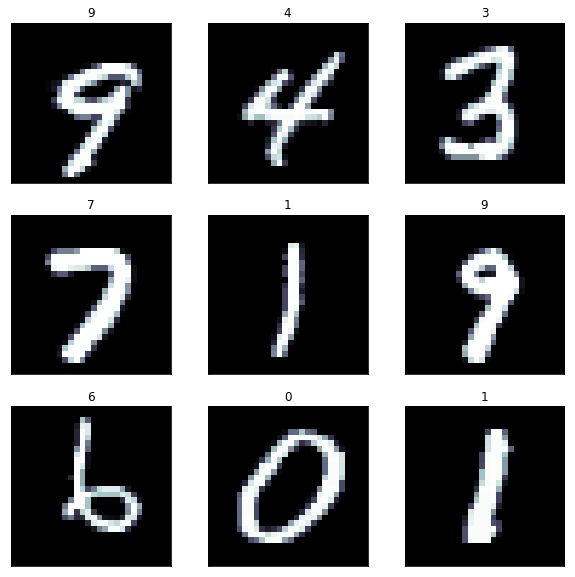

In [11]:
fig=plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(np.squeeze(inputs[i]),cmap='bone')
    plt.title(str(pred[i].item()))
    plt.xticks([])
    plt.yticks([])

In [12]:
lay1_filters = list(model.parameters())[0].detach().numpy()

In [13]:
lay1_filters.shape

(20, 1, 5, 5)

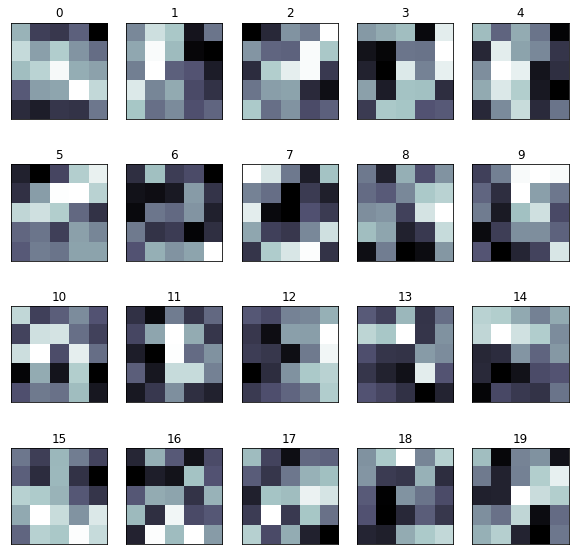

In [14]:
fig=plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(np.squeeze(lay1_filters[i]),cmap='bone')
    plt.title(i)
    plt.xticks([])
    plt.yticks([])

We now extract representations because we want to see how the network transformed one image at the first hidden layer.

http://setosa.io/ev/image-kernels/

In [15]:
[inp, conv1, maxpool1] = model.extract(inputs)

In [16]:
conv1.shape

torch.Size([1000, 20, 24, 24])

In [17]:
conv1[0].shape

torch.Size([20, 24, 24])

In [18]:
x = conv1[0].detach().numpy()

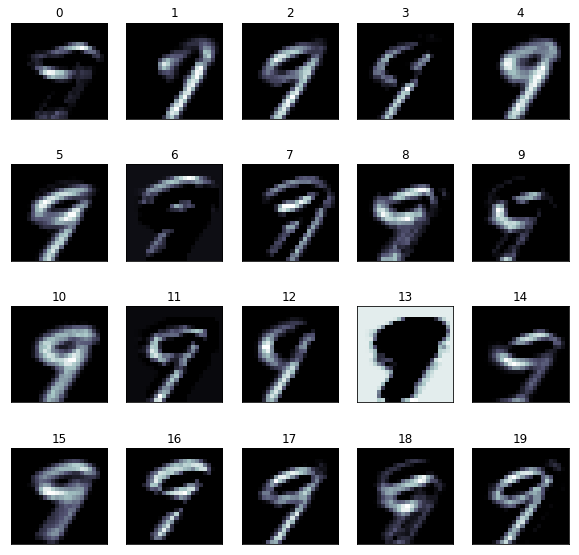

In [19]:
fig=plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(x[i],cmap='bone')
    plt.title(i)
    plt.xticks([])
    plt.yticks([])

In [1]:
from torchvision.models import alexnet
print('The first time this will take a while')
alex = alexnet(pretrained=True)

The first time this will take a while


In [74]:
for p in alex.parameters():
    print(p.shape)

torch.Size([64, 3, 11, 11])
torch.Size([64])
torch.Size([192, 64, 5, 5])
torch.Size([192])
torch.Size([384, 192, 3, 3])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([4096, 9216])
torch.Size([4096])
torch.Size([4096, 4096])
torch.Size([4096])
torch.Size([1000, 4096])
torch.Size([1000])


In [2]:
lay1_filters_alex = list(alex.parameters())[0].detach().numpy()
print(lay1_filters_alex.shape)

(64, 3, 11, 11)


In [6]:
import numpy as np
from matplotlib import pyplot as plt
shape = np.squeeze(lay1_filters_alex[0]).shape
new_shape = np.array(shape)
new_shape = new_shape[[1,2,0]]
new_shape



array([11, 11,  3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

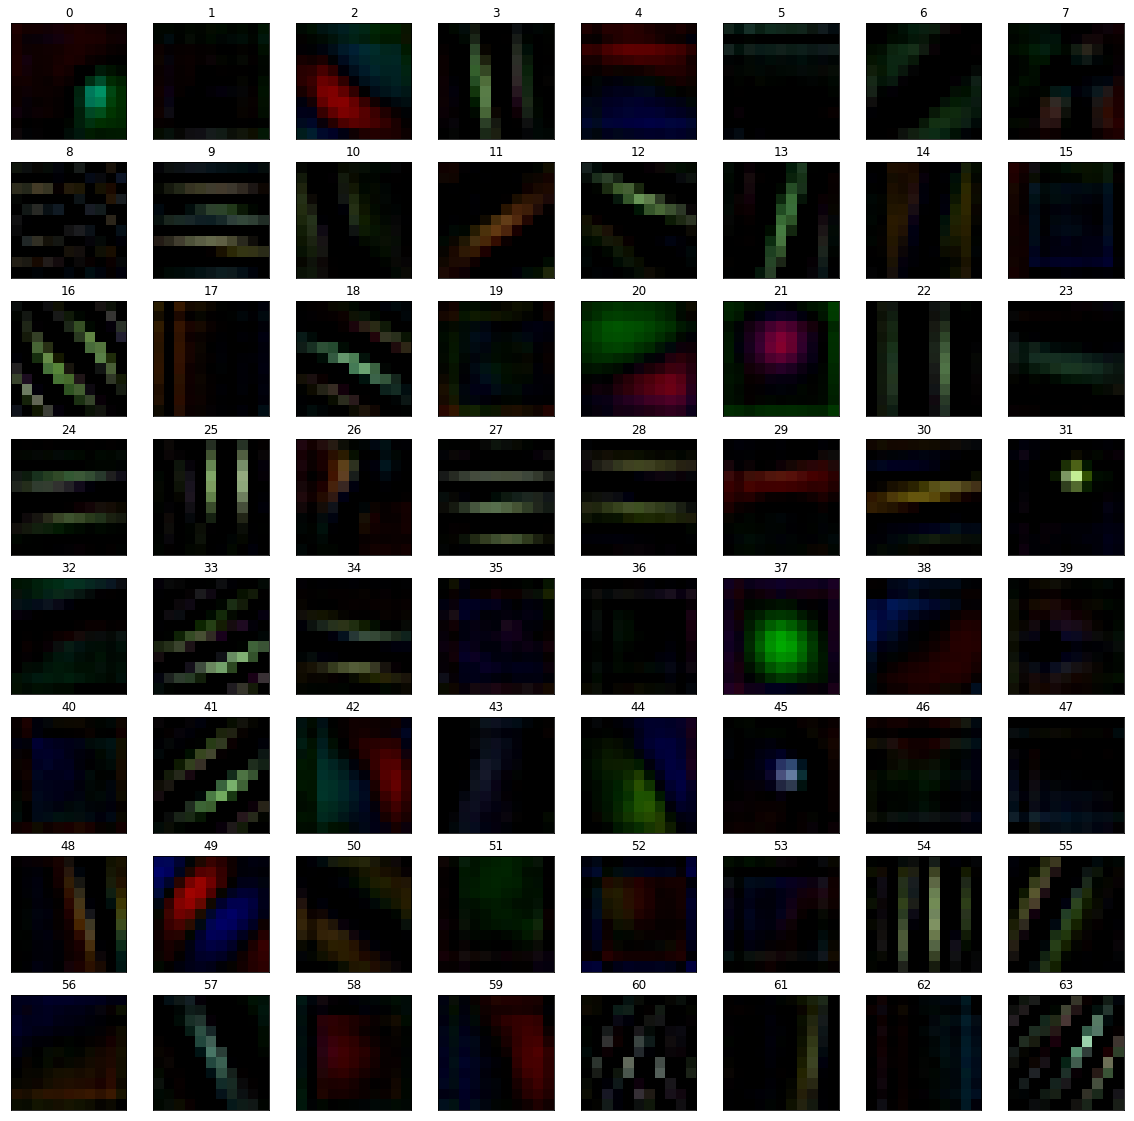

In [7]:
fig=plt.figure(figsize=(20,20))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(lay1_filters_alex[i].transpose(2,1,0))
    plt.title(i)
    plt.xticks([])
    plt.yticks([])